<a href="https://colab.research.google.com/github/Aman-k-s/CropSIH25/blob/main/models/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount drive & create workspace
from google.colab import drive
drive.mount('/content/drive')

# Create working folders in Drive
WORKDIR = "/content/drive/MyDrive/smart_agri"
import os
os.makedirs(WORKDIR, exist_ok=True)
os.chdir(WORKDIR)
!pwd
!mkdir -p data models notebooks


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/smart_agri


In [2]:
#installing required packages
!pip install --quiet torch torchvision pandas numpy scikit-learn matplotlib joblib tqdm


In [3]:
#created synthetic_timeseries.csv
import numpy as np
import pandas as pd
np.random.seed(42)

weeks = 100  # length of series (adjust as needed)
dates = pd.date_range("2023-01-01", periods=weeks, freq="7D")  # weekly

# Synthetic NDVI: baseline with noise and occasional dips
ndvi = 0.7 + 0.05*np.sin(np.linspace(0,6.28,weeks)) + 0.05*np.random.randn(weeks)
ndvi = np.clip(ndvi, 0.15, 0.9)

# Rainfall (mm): mostly small, occasional heavy events
rainfall = np.random.choice([0,0,0,2,5,10,20,30], size=weeks, p=[0.4,0.2,0.15,0.1,0.07,0.04,0.02,0.02])

# Temperature (degC) seasonal-ish + noise
temp = 28 + 3*np.sin(np.linspace(0,3.14,weeks)) + np.random.randn(weeks)*0.8

# Humidity (%) tends to increase with rainfall
humidity = 60 + 0.8*rainfall + np.random.randn(weeks)*3
humidity = np.clip(humidity, 20, 100)

# Heuristic labels for pest outbreak: NDVI drop + recent rainfall + high humidity
pest_outbreak = np.zeros(weeks, dtype=int)
for i in range(2, weeks):
    ndvi_drop = (ndvi[i-2] - ndvi[i])  # drop over ~2 weeks
    if ndvi_drop > 0.06 and (rainfall[i-1] > 10 or rainfall[i-2] > 10) and humidity[i] > 72:
        pest_outbreak[i] = 1

df = pd.DataFrame({
    'date': dates,
    'ndvi': np.round(ndvi, 4),
    'rainfall': rainfall,
    'temperature': np.round(temp, 2),
    'humidity': np.round(humidity, 2),
    'pest_outbreak': pest_outbreak
})
df.to_csv("data/synthetic_timeseries.csv", index=False)
print("Saved:", "data/synthetic_timeseries.csv")
df.head(12)


Saved: data/synthetic_timeseries.csv


,date,ndvi,rainfall,temperature,humidity,pest_outbreak
0,2023-01-01,0.7248,0,28.01,60.60,0
1,2023-01-08,0.6963,0,29.26,58.20,0
2,2023-01-15,0.7387,0,27.98,60.21,0
3,2023-01-22,0.7856,0,30.46,58.84,0
4,2023-01-29,0.7008,10,28.88,68.34,0
5,2023-02-05,0.7039,0,27.79,61.99,0
6,2023-02-12,0.7975,0,27.71,64.76,0
7,2023-02-19,0.7599,0,29.05,56.29,0
8,2023-02-26,0.7008,0,28.57,66.40,0
9,2023-03-05,0.7541,20,29.42,70.14,0


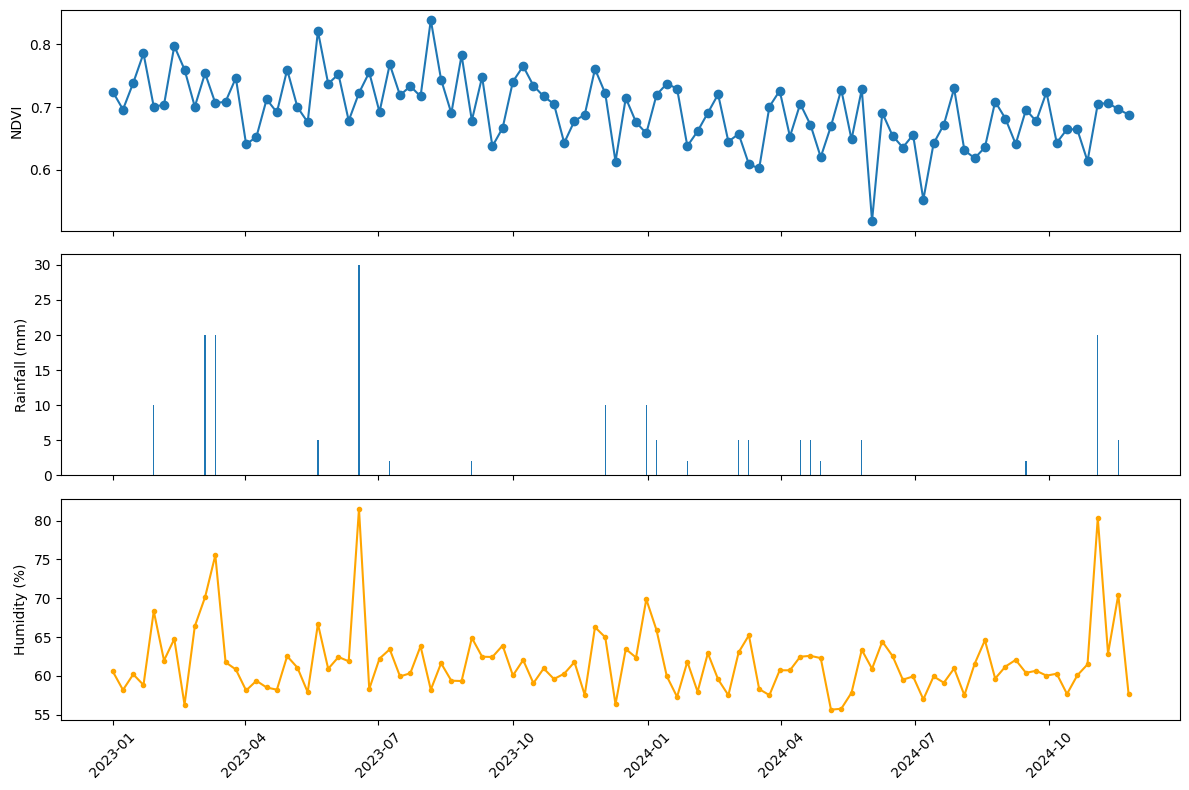

In [4]:
#visualize the synthetic series
import matplotlib.pyplot as plt
df = pd.read_csv("data/synthetic_timeseries.csv", parse_dates=['date'])
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True)
ax[0].plot(df['date'], df['ndvi'], marker='o'); ax[0].set_ylabel('NDVI')
ax[1].bar(df['date'], df['rainfall']); ax[1].set_ylabel('Rainfall (mm)')
ax[2].plot(df['date'], df['humidity'], marker='.', color='orange'); ax[2].set_ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.tight_layout()


In [5]:
#prepare sequences, scaler, dataloaders
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

SEQ_LEN = 6  # sequence length (weeks)
BATCH = 8

df = pd.read_csv("data/synthetic_timeseries.csv")
df = df.dropna().reset_index(drop=True)

# Features and label
features = df[['ndvi','rainfall','temperature','humidity']].values.astype(float)
labels = df['pest_outbreak'].values.astype(int)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Build sequences (X: seq_len x features, y: label at last timestep)
X, y = [], []
for i in range(len(features_scaled) - SEQ_LEN + 1):
    X.append(features_scaled[i:i+SEQ_LEN])
    y.append(labels[i+SEQ_LEN-1])
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32).reshape(-1,1)

# Train/val/test split — time-series style
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

class SeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SeriesDataset(X_train,y_train), batch_size=BATCH, shuffle=True)
val_loader = DataLoader(SeriesDataset(X_val,y_val), batch_size=BATCH, shuffle=False)
test_loader = DataLoader(SeriesDataset(X_test,y_test), batch_size=BATCH, shuffle=False)

# Save scaler for later usage by backend
import joblib
os.makedirs("models", exist_ok=True)
joblib.dump(scaler, "models/risk_scaler.save")
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Scaler saved to models/risk_scaler.save")


Shapes: (66, 6, 4) (14, 6, 4) (15, 6, 4)
Scaler saved to models/risk_scaler.save


In [6]:
#define the LSTM model and training utilities
import torch.nn as nn
import torch

class RiskLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.act = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.act(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [7]:
# training
model = RiskLSTM(input_size=4, hidden_size=64, num_layers=2).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 20

best_val_loss = float('inf')
for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb = Xb.to(device); yb = yb.to(device)
        preds = model(Xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item() * Xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv = Xv.to(device); yv = yv.to(device)
            pv = model(Xv)
            val_loss += criterion(pv, yv).item() * Xv.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'state_dict': model.state_dict()}, "models/risk_lstm_best.pth")
        print("Saved best model to models/risk_lstm_best.pth")


Epoch 1/20 — train_loss: 0.6783, val_loss: 0.6245
Saved best model to models/risk_lstm_best.pth
Epoch 2/20 — train_loss: 0.5579, val_loss: 0.4788
Saved best model to models/risk_lstm_best.pth
Epoch 3/20 — train_loss: 0.3205, val_loss: 0.1797
Saved best model to models/risk_lstm_best.pth
Epoch 4/20 — train_loss: 0.0663, val_loss: 0.0261
Saved best model to models/risk_lstm_best.pth
Epoch 5/20 — train_loss: 0.0116, val_loss: 0.0078
Saved best model to models/risk_lstm_best.pth
Epoch 6/20 — train_loss: 0.0050, val_loss: 0.0044
Saved best model to models/risk_lstm_best.pth
Epoch 7/20 — train_loss: 0.0034, val_loss: 0.0033
Saved best model to models/risk_lstm_best.pth
Epoch 8/20 — train_loss: 0.0028, val_loss: 0.0028
Saved best model to models/risk_lstm_best.pth
Epoch 9/20 — train_loss: 0.0024, val_loss: 0.0025
Saved best model to models/risk_lstm_best.pth
Epoch 10/20 — train_loss: 0.0021, val_loss: 0.0022
Saved best model to models/risk_lstm_best.pth
Epoch 11/20 — train_loss: 0.0019, val_l

In [8]:
#test evaluation & save final model
import numpy as np
ckpt = torch.load("models/risk_lstm_best.pth", map_location=device)
model.load_state_dict(ckpt['state_dict'])
model.eval()

# Test evaluation: collect preds
y_trues = []
y_preds = []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        pv = model(Xb).cpu().numpy().reshape(-1)
        y_preds.extend(pv.tolist())
        y_trues.extend(yb.numpy().reshape(-1).tolist())

# threshold at 0.5 for classification metrics
from sklearn.metrics import classification_report, roc_auc_score
y_pred_labels = [1 if p>=0.5 else 0 for p in y_preds]
print(classification_report(y_trues, y_pred_labels))
try:
    auc = roc_auc_score(y_trues, y_preds)
    print("Test AUC:", auc)
except:
    pass

# Save final model (state dict)
torch.save({'state_dict': model.state_dict()}, "models/risk_lstm_final.pth")
print("Saved final model: models/risk_lstm_final.pth")


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Test AUC: nan
Saved final model: models/risk_lstm_final.pth


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [9]:
#wrapper to load model and predict on last sequence
import joblib
import torch
import numpy as np
from datetime import datetime

# load scaler & model
scaler = joblib.load("models/risk_scaler.save")
ckpt = torch.load("models/risk_lstm_final.pth", map_location=device)
model = RiskLSTM(input_size=4, hidden_size=64, num_layers=2).to(device)
model.load_state_dict(ckpt['state_dict'])
model.eval()

# Prepare last SEQ_LEN rows from raw CSV
df_full = pd.read_csv("data/synthetic_timeseries.csv")
last_seq_raw = df_full[['ndvi','rainfall','temperature','humidity']].values[-SEQ_LEN:]
last_seq_scaled = scaler.transform(last_seq_raw).astype(np.float32)
input_tensor = torch.tensor(last_seq_scaled).unsqueeze(0).to(device)  # shape (1, seq_len, features)

with torch.no_grad():
    risk_prob = float(model(input_tensor).cpu().item())

print(f"Predicted pest outbreak risk_prob (0..1): {risk_prob:.3f}")


Predicted pest outbreak risk_prob (0..1): 0.001


In [10]:
# Colab Cell 9 — fusion and advisory
def compute_health_score(p_cnn_healthy, ndvi_raw, risk_prob, w1=0.4, w2=0.35, w3=0.25):
    # Normalize NDVI from [-] real NDVI roughly 0..1 - here use safe clamp
    ndvi_norm = float(np.clip(ndvi_raw, 0.0, 1.0))
    risk_health = 1.0 - float(risk_prob)
    health_score = w1 * p_cnn_healthy + w2 * ndvi_norm + w3 * risk_health
    return float(np.clip(health_score,0,1))

# Example: mock CNN output (you will replace with real cnn.predict())
mock_cnn_healthy_prob = 0.72   # pretend CNN said 72% healthy for uploaded image
ndvi_latest = float(df_full['ndvi'].values[-1])   # last NDVI raw
health_score = compute_health_score(mock_cnn_healthy_prob, ndvi_latest, risk_prob)
print(f"CNN health prob: {mock_cnn_healthy_prob:.2f}, NDVI: {ndvi_latest:.3f}, Risk: {risk_prob:.3f}")
print(f"Final Crop Health Score: {health_score*100:.1f}%")

# Advisory
if health_score > 0.75:
    advice = "Crop is healthy. Continue current practices."
elif health_score > 0.5:
    advice = "Slight stress. Monitor irrigation & scout for pests."
else:
    advice = "High stress. Immediate intervention required (scouting/pesticide/fertilizer)."

print("Advisory:", advice)


CNN health prob: 0.72, NDVI: 0.688, Risk: 0.001
Final Crop Health Score: 77.9%
Advisory: Crop is healthy. Continue current practices.
